# Table of Contents

# Introduction



# Part 1) Pre-processing and Dataset Visualization

To start, we will pre-process the dataset, removing unnecessary textual elements and formatting it to the input the classifiers understand, as visualize its characteristics such as data distribution, word-count and others.

First, we load the dataset onto a Pandas DataFrame, drop an unneeded column and change a string label to numeric:

In [1]:
import pandas as pd

df = pd.read_csv('../data/proc/comments_lang.csv')

df = df.drop(columns='classe 1')
df.columns=['comment', 'rating', 'rating_b']
df["rating_b"] = df["rating_b"].replace({'nao excelente': 0, 'excelente': 1})
df.head()

,comment,rating,rating_b
0,Good life animation Really smooth animation w...,3,0
1,Terrific Demo Applet This is a really great ap...,5,1
2,Generates Fractal coastlines and allows measur...,5,1
3,Great example of actual use in a High School T...,5,1
4,Excellent demonstration of Bragg's Law I reall...,4,0


Before we can present information about the textual data, we must do a cleanup. This will involve:
- Lowercasing of words,
- Removal of hyperlinks,
- Removal of punctuation (except groups of exclamation and interrogation marks, as they might be semantically relevant) and
- Filtering non-english examples.


In [2]:
# https://pypi.org/project/langdetect/
# from langdetect import detect
# for i in range(len(df)):
#     if(detect(df['comment'][i]) != 'en'):
#         print(i, ': ', detect(df['comment'][i]), '( ', df['comment'][i], ' )')

The language filtering performed served as basis for manual removal on the source file, as there were very few non-english entries.

After the language filtering, we perform lowercasing and removal of hyperlinks and punctuation.

In [3]:
df['comment'] = df['comment'].str.lower()

# df['comment'] = df['comment'].str.replace(r'http\S+\b', '')

# from string import punctuation

# def remove_punctuations(text):
#     for punct in punctuation.replace('?', '').replace('!', ''):
#         text = text.replace(punct, ' ')
#     return text

# df['comment'] = df['comment'].apply(remove_punctuations)
# df.head()


Then, we plot the histogram of categories in the dataset:


[Text(0,0.5,'Percentual'), Text(0.5,0,'Rating')]

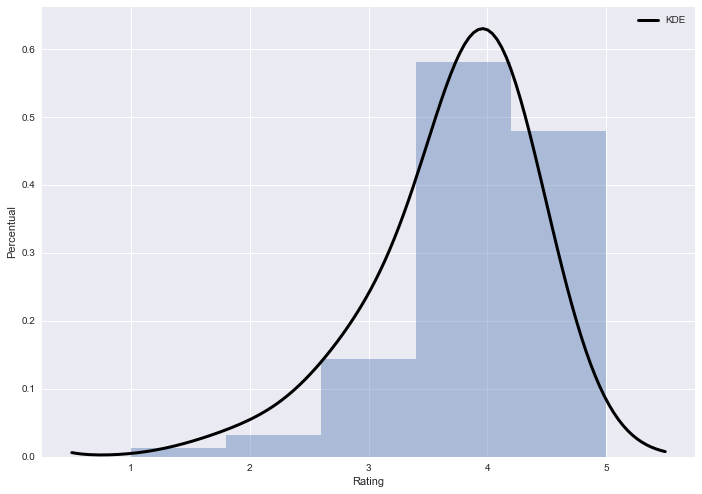

In [4]:
%matplotlib inline
import seaborn as sns, numpy as np
sns.set();
sns.set(rc={'figure.figsize':(11.7,8.27)})
x = df['rating']
from scipy.stats import norm

ax = sns.distplot(x,kde_kws={"color": "k", "lw": 3, 'bw': .5, 'clip': (1,5), "label": "KDE"}, bins=5)
ax.set(xlabel='Rating', ylabel='Percentual')



We can see that from the ratings 1 through 5, the data is considerably imbalanced towards the higher (more positive values).
By transforming the multiclass dataset to a binary, Non-Excelent/Excelent dataset, in which ratings 1-4 form the Non-Excellent and 5 forms the Excellent category, we achieve the following distribution:

[Text(0,0.5,'Comments'), Text(0.5,0,'Rating')]

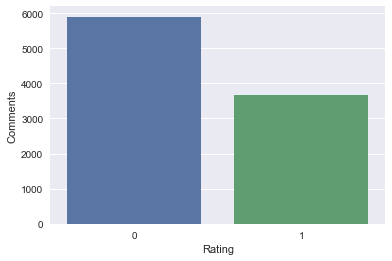

In [5]:
x_2 = df['rating_b']
ax_2 = sns.countplot(x_2)
ax_2.set(xlabel='Rating', ylabel='Comments')

We can see from the graph that with the binary distribution, the Non-Excellent class has around 6000 examples, while class Excellent amounts to a little below 4000, which allows for a more balanced training.

Next, we present the average word count for the 5-category dataset, as well as the binary one. We also consider average word counts if filtering of stop words is used:

In [6]:
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS
# If not donwloaded, uncomment this!
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stop.union(stopwords.words('english'))

# https://pypi.org/project/stop-words/
from stop_words import get_stop_words
stop = stop.union(get_stop_words('en'))

df['comment_stop'] = df['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# from string import punctuation

# def remove_punctuations(text):
#     for punct in punctuation.replace('?', '').replace('!', ''):
#         text = text.replace(punct, ' ')
#     return text

# df['comment_stop'] = df['comment_stop'].apply(remove_punctuations)
####


df['count'] = df['comment'].str.split().str.len()
df['count_stop'] = df['comment_stop'].str.split().str.len()



word_count_5_cat = pd.DataFrame(columns = ['Rating', 'Average (with stop-words)', 'Average (without stop-words)'])
word_count_2_cat = pd.DataFrame(columns = ['Class', 'Average (with stop-words)', 'Average (without stop-words)'])

for i in range(1, 6):
    word_count_5_cat.loc[i] = [i,
                               int(df[df['rating'] == i]['count'].mean()),
                               int(df[df['rating'] == i]['count_stop'].mean())]

for i in range(2):
    word_count_2_cat.loc[i] = ['Non-Excellent' if i == 0 else 'Excellent',
                               int(df[df['rating_b'] == i]['count'].mean()),
                               int(df[df['rating_b'] == i]['count_stop'].mean())]

display(word_count_5_cat)
display(word_count_2_cat)

,Rating,Average (with stop-words),Average (without stop-words)
1,1,42,19
2,2,64,30
3,3,70,33
4,4,75,36
5,5,70,34


,Class,Average (with stop-words),Average (without stop-words)
0,Non-Excellent,73,35
1,Excellent,70,34


As can be seen, the removal of stop-words reduces to around half average word count for the examples, both for 5 categories and binary. We will experiment with both in the Classification phase to determine whether this translates to better results.

## Part 1.5) Over-sampling
After the rest of the classification workflow is done, we may come back to over-sample the training data and check whether it impacts the classifiers positively.

https://beckernick.github.io/oversampling-modeling/
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
https://imbalanced-learn.org/en/stable/over_sampling.html

# Part 2) Classification

To start, we separate the data into training set and test set, so that the feature extraction is done separately. That way, the model can only learn vocabulary on the training set, mimicking the real life application of out-of-sample data.

In [7]:
from sklearn.model_selection import train_test_split

docs_train, docs_test, y_train, y_test = train_test_split(
    df['comment'], df['rating_b'], test_size=0.25)

Then, we set up the parameters which will be varied in the complete training session.

In [8]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = {
    "None": None,
    "200": 200,
    "500": 500,
    "1000": 1000,
    "5000": 5000,
    "10000": 10000
}

n_grams = {
    "1": (1, 1),
    "2": (2, 2),
    "3": (3, 3),
    "1-2": (1, 2),
    "1-3": (1, 3),
    "2-3": (2, 3)
}

stop_words = {
    "No": None,
    "Yes": ENGLISH_STOP_WORDS
}

n_categories = {
    "Exc./Non-Exc": "rating_b",
    "1-5": "rating"
}

vectorizers = {
    "Count": CountVectorizer,
    "TF-IDF": TfidfVectorizer
}

classifiers = {
    "Naïve Bayes": MultinomialNB(),
    "Support Vector Machine": CalibratedClassifierCV(LinearSVC(max_iter=10000), cv=3),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=4000),
    "K Nearest Neighbors": KNeighborsClassifier()
}

First, we classify using all default settings, so that we can get a good baseline view of the classifiers:

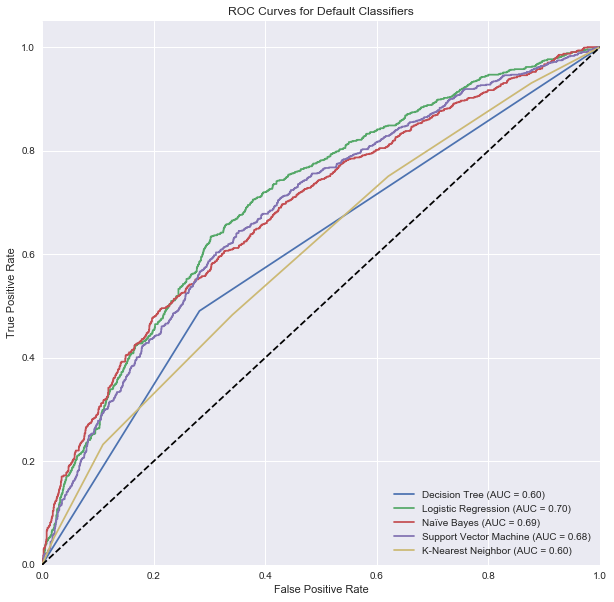

In [9]:
count_vec = CountVectorizer()
tfidf_vec = TfidfVectorizer()
X_train = count_vec.fit_transform(docs_train)

classifiers={
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=4000),
    'Naïve Bayes': MultinomialNB(),
    'Support Vector Machine': CalibratedClassifierCV(LinearSVC(max_iter=10000), cv=3),
    'K-Nearest Neighbor': KNeighborsClassifier()
}

X_test = count_vec.transform(docs_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for key, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    roc_score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label='{0} (AUC = {1:.2f})'.format(key,roc_score))

plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Default Classifiers')
plt.legend(loc='lower right')
plt.show()


We can see that, while 0.7 is an above average  result, we must investigage whether the fine-tuning of parameters can lead to better results, or the dataset reaches its potential for these classifiers at this baseline. Also it is important to be noted that the SVM might not converge to the Count Vectorizer, because of the difference of magnitudes of some features (words frequently used have high values, while most other words have 0 occurrences in word vectors.

Next, we use TF-IDF to try to improve our results:

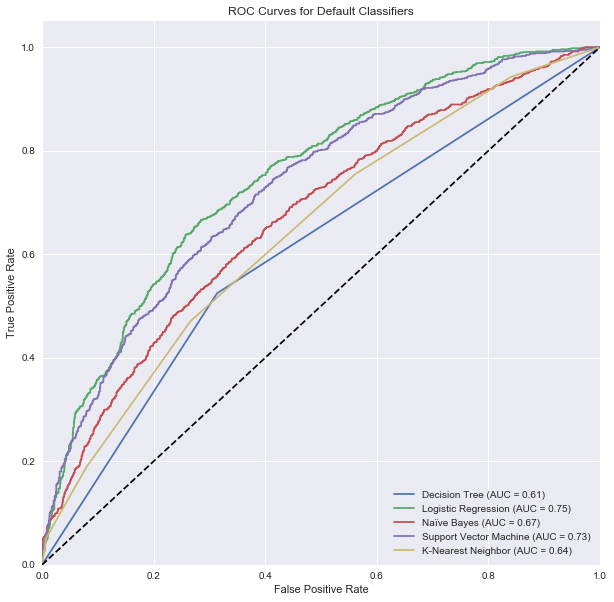

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vec = TfidfVectorizer()

X_train = tf_vec.fit_transform(docs_train)
X_test = tf_vec.transform(docs_test)
plt.figure(figsize=(10, 10))
for key, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    roc_score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label='{0} (AUC = {1:.2f})'.format(key,roc_score))
    
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Default Classifiers')
plt.legend(loc='lower right')
plt.show()


We can see a slight improvement from the previous results, which makes us presume that further fine-tuning may provide even better results.
That being said, we must investigate this in a more streamlined way, so that we don't take forever investigating each parameter at a time. This investigation will be in two parts:
1) We train all variations for the following parameters in a regular loop: N-gram range, removal of stop-words and type of vectorizer.
2) We take the two best configurations in the prior step and tune their hyperparameters using Scikit-learn's GridSearchCV.

## 2.1) Classifying for N-grams, stop-words and type of vectorizer

In [11]:
#This process can take quite some time, hence the saving of the results to a CSV for further usage
import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
import os
if os. path. isfile('results.csv') is not True:
    docs_train, docs_test, y_train, y_test = train_test_split(
        df['comment'], df['rating_b'], test_size=0.25, random_state=None)

    data = []
    count = 1

    n_tests = len(max_features)*len(n_grams)*len(stop_words)*len(vectorizers)*len(classifiers)
    print("Number of tests: ", n_tests)

    ### Grid Search ###
    for feat_key, max_feature in max_features.items():
        for gram_key, gram in n_grams.items():
            for stop_key, stop_word in stop_words.items():
                for class_key, clf in classifiers.items():
                    for vec_key, vec in vectorizers.items():
                        time_start = time.time()

                        vectorizer = vec(
                            analyzer='word',
                            lowercase=True,
                            stop_words=stop_word,
                            ngram_range=gram,
                            max_features=max_feature
                        )

                        X_train = vectorizer.fit_transform(docs_train)
                        X_test = vectorizer.transform(docs_test)
                        clf.fit(X_train, y_train)

                        y_pred = clf.predict(X_test)
                        y_pred_prob = clf.predict_proba(X_test)[:, 1]
                        accuracy = accuracy_score(y_test, y_pred)
                        roc_auc = roc_auc_score(y_test, y_pred_prob)
                        report = classification_report(y_test, y_pred,  output_dict=True)
                        kappa = cohen_kappa_score(y_test, y_pred)
                        line = [
                            '{0:.2f}'.format(time.time() - time_start),
                            class_key,
                            feat_key,
                            gram_key,
                            stop_key,
                            vec_key,
                            '{0:.2f}'.format(accuracy),
                            '{0:.2f}'.format(report['0']['precision']),
                            '{0:.2f}'.format(report['1']['precision']),
                            '{0:.2f}'.format(report['0']['recall']),
                            '{0:.2f}'.format(report['1']['recall']),
                            '{0:.2f}'.format( report['0']['f1-score']),
                            '{0:.2f}'.format(report['1']['f1-score']),
                            '{0:.2f}'.format(kappa),
                            '{0:.2f}'.format(roc_auc)
                        ]
                        print(count, "/", n_tests, ": ", line)
                        count += 1
                        data.append(line)

    ### Dumping Results to csv ###
    df = pd.DataFrame(data, columns=[
        'Time Elapsed',
        'Classifier',
        'Number of Features',
        'N-gram Range',
        'Stop-words',
        'Vectorizer',
        'Accuracy (%)',
        'Recall (Negative)',
        'Recall (Positive)',
        'Precision (Negative)',
        'Precision (Positive)',
        'F1 (Negative)',
        'F1 (Positive)',
        'Kappa',
        'ROC AUC'])

    df.to_csv('results.csv', index=False)

With these general results, we select the 2 best for each classifier (in ROC AUC values):

In [12]:
df = pd.read_csv('results.csv')

df = df.sort_values(by='ROC AUC', ascending=False)
df.head()

df_best_2 = pd.DataFrame(columns=df.columns)
for clf_key in classifiers:
    df_best_2 = pd.concat([df_best_2, df.loc[df['Classifier'] == clf_key][:2]])
df_best_2.sort_values(by='ROC AUC', ascending=False)

,Time Elapsed,Classifier,Number of Features,N-gram Range,Stop-words,Vectorizer,Accuracy (%),Recall (Negative),Recall (Positive),Precision (Negative),Precision (Positive),F1 (Negative),F1 (Positive),Kappa,ROC AUC
87,6.34,Support Vector Machine,None,1-3,No,TF-IDF,0.70,0.74,0.64,0.79,0.57,0.76,0.60,0.36,0.77
67,2.86,Support Vector Machine,None,1-2,No,TF-IDF,0.70,0.72,0.65,0.82,0.51,0.77,0.57,0.35,0.77
685,4.43,Naïve Bayes,10000,1-3,No,TF-IDF,0.69,0.68,0.69,0.90,0.36,0.78,0.47,0.28,0.74
625,1.67,Naïve Bayes,10000,2,No,TF-IDF,0.68,0.67,0.72,0.93,0.28,0.78,0.41,0.24,0.74
669,4.94,K-Nearest Neighbor,10000,1-2,No,TF-IDF,0.61,0.73,0.50,0.57,0.67,0.64,0.57,0.23,0.66
569,8.38,K-Nearest Neighbor,5000,1-3,No,TF-IDF,0.60,0.71,0.50,0.58,0.64,0.64,0.56,0.21,0.65
60,14.02,Decision Tree,None,1-2,No,Count,0.65,0.70,0.56,0.75,0.50,0.72,0.53,0.25,0.62
80,34.75,Decision Tree,None,1-3,No,Count,0.65,0.69,0.56,0.76,0.48,0.72,0.52,0.25,0.62


We can draw a few preliminary conclusions from the above table:

- For the maximum number of features, choosing a large number (or even not restricting size) seems to get better results;
- For the n-gram ranges, we see that most techniques can benefit from features formed by more than one word, which agrees with our assumption that meaning in text most of the time doesn't come from isolated words.
- For stop-words, contrary to our expectations, no technique seemed to benefit from their removal. It may be that, with TF-IDF tokenizer (which most in the list used), stop-words are simply deemed irrelevant, or their presence in n-grams larger than 1-gram may contribute to the analysis.
- For the Vectorizer, it was expected that tf-idf would be preferred for several reasons, including the normalization of data (especially for the convergence of SVM's) and the increase of importance in meaningful, yet infrequent words, as well as the reduction of importance in frequent, generally meaninless words (e.g. stop-words).
- Decision Trees seemed to work better with the Count Vectorizer, which can be explained by its preferability to values with different magnitudes, which can make it easier to build the decision rules.
- Both Decision Trees and K-Nearest Neighbors seem to do poorly in this dataset, and are possibly not well suited to text analytics problems. More specific formulation of the problem to the techniques, as well as the data representation may improve these results.

Next, we tune the hyperparameters of these techniques to see if we can improve them further.


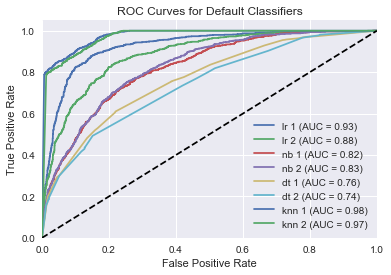

In [13]:
from sklearn.pipeline import Pipeline
import pickle

parameters = {
    'lr': [{
        'vec__max_df': (0.25, 0.5, 0.75, 1.0),
        'vec__min_df': (1, 10, 50),
        'tfidf__use_idf': (True, False),
        'tfidf__sublinear_tf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__C': (1, 0.1, 0.01, 0.001, 0.0001),
        'clf__tol': (1e-5, 1e-4, 1e-3),
    }, 
        [TfidfVectorizer(ngram_range=(1,2)),
        TfidfVectorizer(max_features=10000, ngram_range=(1,2))]
    ],
    'svm': [{
        'vec__max_df': (0.25, 0.5, 0.75, 1.0),
        'vec__min_df': (1, 10, 50),
        'tfidf__use_idf': (True, False),
        'tfidf__sublinear_tf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__C': (10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
        'clf__tol': (1e-5, 1e-4, 1e-3)
    }, 
        [TfidfVectorizer(ngram_range=(1,3)),
        TfidfVectorizer(ngram_range=(1,2))]
    ],
    'nb': [{
        'vec__max_df': (0.5, 0.625, 0.75, 0.875, 1.0),
        'vec__min_df': (1, 5, 10, 20, 50),
        'tfidf__use_idf': (True, False),
        'tfidf__sublinear_tf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
    }, 
        [TfidfVectorizer(max_features=10000, ngram_range=(1,3)),
        TfidfVectorizer(max_features=10000, ngram_range=(2,2))]
    ],
    'dt': [{
        'vec__max_df': (0.5, 0.625, 0.75, 0.875, 1.0),
        'vec__min_df': (1, 5, 10, 20, 50),
        'clf__criterion': ('gini', 'entropy'),
        'clf__max_depth': (None, 1, 2, 4, 6, 8, 10, 16),
        'clf__splitter': ('best', 'random')
    }, 
        [CountVectorizer(ngram_range=(1,2)),
        CountVectorizer(ngram_range=(1,3))]
    ],
    'knn': [{
        'vec__max_df': (0.5, 0.75, 1.0),
        'vec__min_df': (1, 5, 20),
        'tfidf__use_idf': (True, False),
        'tfidf__sublinear_tf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__metric': ('minkowski', 'euclidean'),
        'clf__n_neighbors': range(1, 6),
        'clf__weights': ('uniform', 'distance')
    }, 
        [TfidfVectorizer(max_features=10000, ngram_range=(1,2)),
        TfidfVectorizer(max_features=5000, ngram_range=(1,3))]
    ],
}

classifiers = {
    "lr": LogisticRegression(solver='lbfgs', max_iter=4000),
    "svm": CalibratedClassifierCV(LinearSVC(max_iter=10000), cv=3),
    "nb": MultinomialNB(),
    "dt": DecisionTreeClassifier(),
    "knn": KNeighborsClassifier()
}

for key, parameter in parameters.items():
    for i in range(1,3):
        pipeline = Pipeline([
            ('vec',   parameter[1][i-1]),
            ('clf',   classifiers[key])
        ])

        pickle_path = 'results_' + key + '_' + str(i) + '.pkl'
        if os.path.isfile(pickle_path) is not True and __name__ == "__main__":
            grid_search = GridSearchCV(
                pipeline, parameter[0], n_jobs=-1, verbose=51, scoring='roc_auc')
            pickling_on = open(pickle_path, "wb")
            grid_search.fit(docs_train, y_train)
            pickle.dump(grid_search, pickling_on)
            pickling_on.close()
        else:
            pickling_on = open(pickle_path, "rb")
            grid_search = pickle.load(pickling_on)
        
        if key != 'svm':
            y_pred_proba = grid_search.predict_proba(docs_test)[:,1]
            roc_score = roc_auc_score(y_test, y_pred_proba)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label='{0} (AUC = {1:.2f})'.format(key + ' ' + str(i),roc_score))
        
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Default Classifiers')
plt.legend(loc='lower right')
plt.show()